In [1]:
import os
import pickle 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

def gaussian_blur(img, kernel=5):
    output = cv2.GaussianBlur(img,(kernel,kernel),0)
    return output

def warp_img(img,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,M,Minv

def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    output = cv2.bitwise_and(img,img, mask= mask)
    return output

def d_threshold(img, sobel_kernel=3, threshold=(0, np.pi/2)):
    x_simage = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    y_simage = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    z = np.arctan2(np.absolute(y_simage), np.absolute(x_simage))
    output = 0*z
    output[(z>=threshold[0]) & (z<=threshold[1])] = 1
    return output

def abs_s_threshold(img, orientation='x', threshold=(0, 255)):
    if orientation=='x':
        sobel_image = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    if orientation=='y':
        sobel_image = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(sobel_image)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    output = 0*img_sobel
    output[(img_sobel >= threshold[0]) & (img_sobel <= threshold[1])] = 1
    return output

def m_threshold(img, threshold=(0, 255)):
    x_simage = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    y_simage = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    sobel_image = np.sqrt(x_simage**2 + y_simage**2)
    sobel_image = np.uint8(sobel_image*255/np.max(sobel_image))
    output = 0*sobel_image
    output[(sobel_image>=threshold[0]) & (sobel_image<=threshold[1]) ]=1
    return output

def calc_avg(a, n=3):
    output = np.cumsum(a, dtype=float)
    output[n:] = output[n:] - output[:-n]
    return output[n - 1:] / n

def curve_form(r,z):
    A = r[0]
    B = r[1]
    output = (1+(2*A*z+B)**2)**1.5/2/A
    return output

def connect_points(img,corners,color):
    corners = np.int_(corners)
    for i in range(10):
        x1 = corners[0][i][0]
        y1 = corners[0][i][1]
        x2 = corners[0][i+1][0]
        y2 = corners[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

def get_value(t,r):
    return r[0]*t**2+r[1]*t+r[2]

def lane_masking(img,poly_fit,w_size):
    final_mask = np.zeros_like(img)
    img_size = np.shape(img)
    mask_points = []
    others = []
    for i in range(8):
        part_image0 = img_size[0]-img_size[0]*i/8
        part_image1 = img_size[0]-img_size[0]*(i+1)/8
        point_img = (part_image0+part_image1)/2
        others.append(point_img)
        p_mask = np.round(poly_fit[0]*point_img**2 + poly_fit[1]*point_img + poly_fit[2])
        mask_points.append(p_mask)
        final_mask[part_image1:part_image0,p_mask-w_size:p_mask+w_size] = 1.     
    return final_mask, np.array(mask_points),np.array(others)

In [3]:
def start_masking(img,w_size):
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    box_size = img_size[1]/50.
    avg_lane = np.mean(img[img_size[0]/2:,:],axis=0)
    avg_lane = calc_avg(avg_lane,box_size)
    points = find_peaks_cwt(avg_lane,[100], max_distances=[800])
    valid_point = np.array([avg_lane[points[i]] for i in range(len(points)) ])
    sorted_point = np.argsort(-valid_point)
    right_peak_point = points[sorted_point[0]]
    left_peak_point = points[sorted_point[1]]
    if right_peak_point<left_peak_point:
        temp = right_peak_point
        right_peak_point = left_peak_point
        left_peak_point = temp
    left_min_point = left_peak_point-w_size
    left_max_point = left_peak_point+w_size
    right_min_point = right_peak_point-w_size
    right_max_point = right_peak_point+w_size
    left_lane_mask = np.zeros_like(img)
    right_lane_mask = np.zeros_like(img)
    old_right_peak_point = right_peak_point
    old_left_peak_point = left_peak_point
    for i in range(8):
        part_image0 = img_size[0]-img_size[0]*i/8
        part_image1 = img_size[0]-img_size[0]*(i+1)/8
        avg_part_image = np.mean(img[part_image1:part_image0,:],axis=0)
        avg_part_image = calc_avg(avg_part_image,box_size)
        points = find_peaks_cwt(avg_part_image,[100], max_distances=[800])
        if len(points)>1.5:
            valid_point = np.array([avg_lane[points[i]] for i in range(len(points)) ])
            sorted_point = np.argsort(-valid_point)
            right_peak_point = points[sorted_point[0]]
            left_peak_point = points[sorted_point[1]]
            if right_peak_point<left_peak_point:
                temp = right_peak_point
                right_peak_point = left_peak_point
                left_peak_point = temp
        else:
            if len(points)==1:
                if (np.abs(points[0]-old_right_peak_point)<np.abs(points[0]-old_left_peak_point)):
                    right_peak_point = points[0]
                    left_peak_point = old_left_peak_point
                else:
                    left_peak_point = points[0]
                    right_peak_point = old_right_peak_point
            else:
                left_peak_point = old_left_peak_point
                right_peak_point = old_right_peak_point
        if np.abs(left_peak_point-old_left_peak_point)>=80:
            left_peak_point = old_left_peak_point
        if np.abs(right_peak_point-old_right_peak_point)>=80:
            right_peak_point = old_right_peak_point
        left_lane_mask[part_image1:part_image0,left_peak_point-w_size:left_peak_point+w_size] = 1.
        right_lane_mask[part_image1:part_image0,right_peak_point-w_size:right_peak_point+w_size] = 1.
        old_left_peak_point = left_peak_point
        old_right_peak_point = right_peak_point
    return left_lane_mask,right_lane_mask

In [4]:
def perspective_transform(img):
    img_size = img.shape
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2.6)
    ctr_window = c_window + .25*np.uint(img_size[1]/2.6)
    cbl_window = c_window - .95*np.uint(img_size[1]/2)
    cbr_window = c_window + .95*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])
    warped,M_warp,Minv_warp = warp_img(img,src,dst,(img_size[1],img_size[0])) # returns birds eye img
    return warped,M_warp,Minv_warp

In [5]:
def go(image):
    global old_left_f   
    global old_right_f
    global old_left_c
    global old_right_c
    global set_to_old
    global left_mask_out
    global right_mask_out
    
    image = undistort_image(image, mtx_camera , dist_camera )
    image = gaussian_blur(image, kernel=5)
    img_size = np.shape(image)

    warped,M_warp,Minv_warp = perspective_transform(image)
    image_hsv = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 100, 255, 255])
    white_hsv_low  = np.array([  0,   0,   150])
    white_hsv_high = np.array([ 255,  100, 255])

    yellow_mask = color_mask(image_hsv,yellow_hsv_low,yellow_hsv_high)
    white_mask = color_mask(image_hsv,white_hsv_low,white_hsv_high)
    mask_lane = cv2.bitwise_or(yellow_mask,white_mask)
    
    image_hls = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    a = image_hls[:,:,1]
    xa = abs_s_threshold(a,'x',(50,225))
    ya = abs_s_threshold(a,'y',(50,225))
    l_channel = np.copy(cv2.bitwise_or(xa,ya))
    
    a = image_hls[:,:,2]
    xa = abs_s_threshold(a,'x',(50,255))
    ya = abs_s_threshold(a,'y',(50,255))
    s_channel = np.copy(cv2.bitwise_or(xa,ya))
    
    channels_ls = cv2.bitwise_or(l_channel,s_channel)
    channels_ls = gaussian_blur(channels_ls,25)

    final_channel = np.zeros_like(channels_ls)
    final_channel[(mask_lane>=.5)|(channels_ls>=.5)]=1
    
    #START
    right_cols = (255,255,255)
    left_cols = (255,255,255)
    if set_to_old == 0:
        final_channel = gaussian_blur(final_channel,5)
        left_mask_out,right_mask_out = start_masking(final_channel,40)     

    lined_image_l = np.copy(final_channel)
    lined_image_l = cv2.bitwise_and(final_channel,final_channel,
                                mask = left_mask_out)
    vals = np.argwhere(lined_image_l>.5)
    if len(vals)<5:
        left_m = old_left_f
        left_cols = old_left_c
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        left_m = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(lined_image_l,yellow_mask))>1000:
            left_cols = (255,255,0)

    lined_image_r = np.copy(final_channel)
    lined_image_r = cv2.bitwise_and(final_channel,final_channel,
                                mask = right_mask_out)
    vals = np.argwhere(lined_image_r>.5)
    if len(vals)<5:
        right_m = old_right_f
        right_cols = old_right_c
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        right_m = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(lined_image_r,yellow_mask))>1000:
            right_cols = (255,255,0)
 
    if set_to_old == 0:
        set_to_old = 1
        old_right_f = right_m
        old_left_f  = left_m

    err_p_R = np.sum((right_m[0]-old_right_f[0])**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_m = old_right_f
        right_cols = old_right_c
    else:
        right_m = .05*right_m+.95*old_right_f
        
    err_p_L = np.sum((left_m[0]-old_left_f[0])**2)
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_m =  old_left_f
        left_cols = old_left_c
    else:
        left_m =  .05* left_m+.95* old_left_f
        
    left_mask_out,left_corners,img_corners = lane_masking(final_channel,left_m,window_size)
    right_mask_out,right_corners,img_corners = lane_masking(final_channel,right_m,window_size)

    
    right_p = np.arange(11)*img_size[0]/10
    rightq = right_m[0]*right_p**2 + right_m[1]*right_p + right_m[2]

    left_p = np.arange(11)*img_size[0]/10
    leftq = left_m[0]*left_p**2 + left_m[1]*left_p + left_m[2]
    
    z_holder = np.zeros_like(final_channel).astype(np.uint8)
    c_transform = np.dstack((z_holder, z_holder, z_holder))

    corners_left = np.array([np.transpose(np.vstack([leftq, left_p]))])
    corners_right = np.array([np.flipud(np.transpose(np.vstack([rightq, right_p])))])
    corners = np.hstack((corners_left, corners_right))

    b_left = get_value(img_size[0],left_m)
    b_right = get_value(img_size[0],right_m)

    p_center = (b_left+b_right)/2.0
    
    distance_difference = p_center - img_size[1]/2
    distance_difference = np.round(distance_difference/2.81362,2)
    difference_printout = 'Distance from center: '+str(distance_difference/100)+'m'
    cv2.fillPoly(c_transform, np.int_([corners]), (0,255, 0))

    connect_points(c_transform,np.int_(corners_left),left_cols)
    connect_points(c_transform,np.int_(corners_right),right_cols)
    out_trans = cv2.warpPerspective(c_transform, Minv_warp, (image.shape[1], image.shape[0])) 
    output = cv2.addWeighted(image, 1, out_trans, 0.5, 0)
    
    left_curve = curve_form(left_m,img_size[0]/2)
    Right_curve = curve_form(right_m,img_size[0]/2)
    
    curve_numb = 'Radius of Curvature: Right = ' + str(np.round(Right_curve,2)) + ', Left = ' + str(np.round(left_curve,2)) 
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(output, curve_numb, (30, 50), font, 1, (255,255,255), 2)
    cv2.putText(output, difference_printout, (30, 100), font, 1, (255,255,255), 2)
    
    old_right_f = right_m
    old_left_f  = left_m
    old_right_c = right_cols
    old_left_c = left_cols
    return output

In [6]:
data = pickle.load( open('camera_calibration.pkl','rb'))
mtx_camera = data[0]
dist_camera = data[1]
window_size = 60

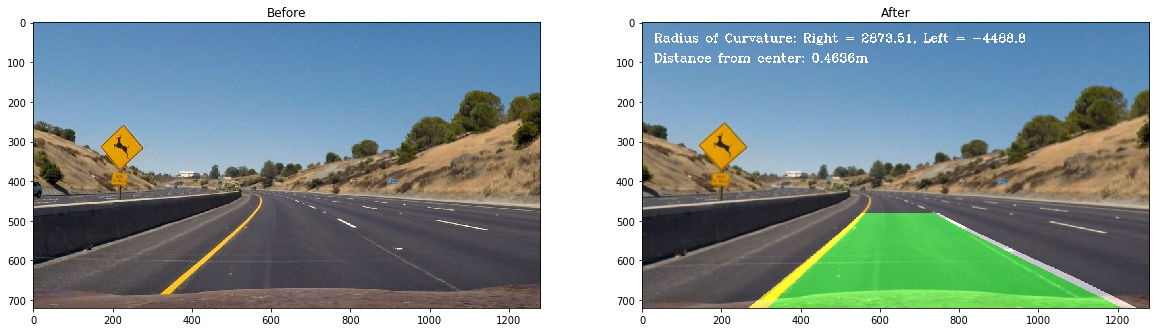

In [7]:
image = mpimg.imread('test_images/test2.jpg')

set_to_old = 0
final_result = go(image)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(final_result)
plt.title('After')

In [8]:
set_to_old = 0
output_name = 'project_video_output.mp4'
input_video = VideoFileClip("project_video.mp4");
output_video = input_video.fl_image(go)
%time output_video.write_videofile(output_name, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:05<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 22s, sys: 24.2 s, total: 7min 47s
Wall time: 4min 6s


In [9]:
set_to_old = 0
output_name = 'challenge_video_output.mp4'
input_video = VideoFileClip("challenge_video.mp4");
output_video = input_video.fl_image(go)
%time output_video.write_videofile(output_name, audio=False);

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:38<00:00,  4.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 54s, sys: 9 s, total: 3min 3s
Wall time: 1min 38s
